In [2]:
!pip install statsmodels

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import save_model

In [6]:
googl_data = pd.read_csv(r"C:\Users\dmade\Downloads\archive (12)\googl_daily_prices.csv")
googl_data

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-28,173.160,175.265,171.9107,172.360,34284926.0
1,2025-05-27,170.160,173.170,170.0000,172.900,37995670.0
2,2025-05-23,169.055,169.960,167.8900,168.470,35211439.0
3,2025-05-22,171.850,176.770,170.7100,170.870,74864418.0
4,2025-05-21,163.690,173.140,163.5600,168.560,73415956.0
...,...,...,...,...,...,...
5222,2004-08-25,104.760,108.000,103.8800,106.000,9188600.0
5223,2004-08-24,111.240,111.600,103.5700,104.870,15247300.0
5224,2004-08-23,110.760,113.480,109.0500,109.400,18256100.0
5225,2004-08-20,101.010,109.080,100.5000,108.310,22834300.0


In [8]:
googl_data.describe()

,1. open,2. high,3. low,4. close,5. volume
count,5227.000000,5227.000000,5227.000000,5227.000000,5.227000e+03
mean,764.703352,772.330542,756.689687,764.645466,9.735276e+06
std,612.976706,619.095583,606.442500,612.900958,1.205150e+07
min,85.400000,86.520000,83.340000,83.430000,4.656380e+05
25%,399.990000,405.000000,393.620000,398.950000,1.813494e+06
50%,585.930000,589.300000,579.180000,584.180000,4.565200e+06
75%,999.910000,1008.085000,992.075000,1002.570000,1.310330e+07
max,3025.000000,3030.931500,2977.980000,2996.770000,1.277476e+08


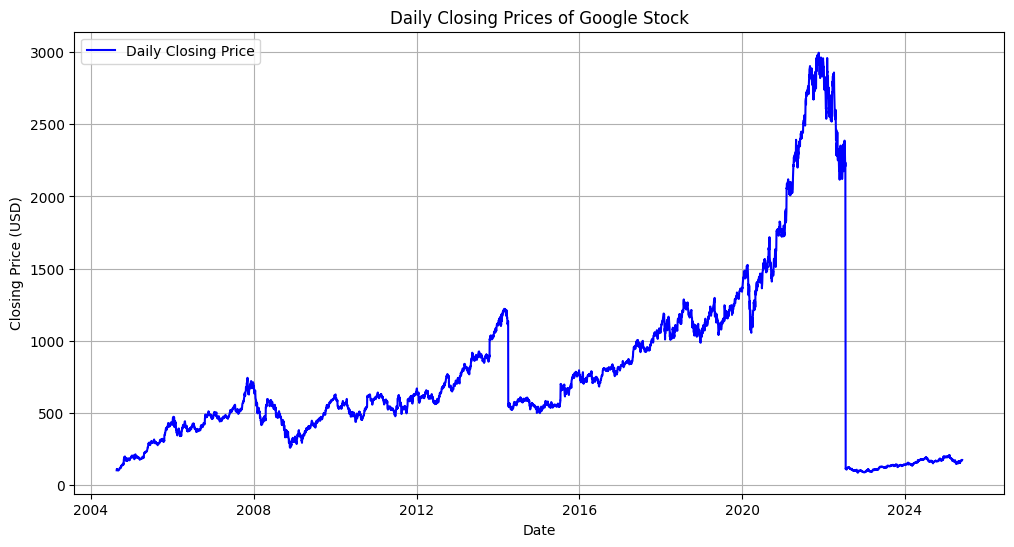

In [10]:
googl_data['date'] = pd.to_datetime(googl_data['date'])
plt.figure(figsize=(12, 6))
plt.plot(googl_data['date'], googl_data['4. close'], label='Daily Closing Price', color='blue')
plt.title('Daily Closing Prices of Google Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid()
plt.show()

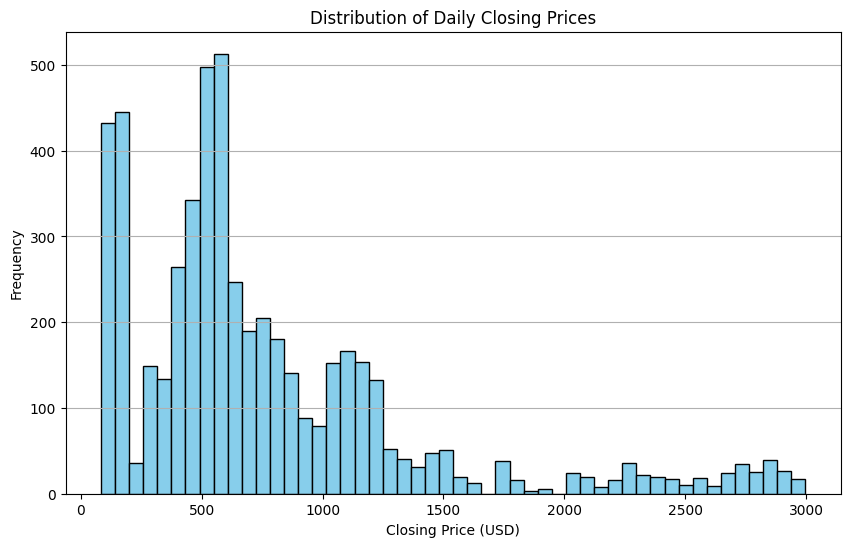

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(googl_data['4. close'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Closing Prices')
plt.xlabel('Closing Price (USD)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

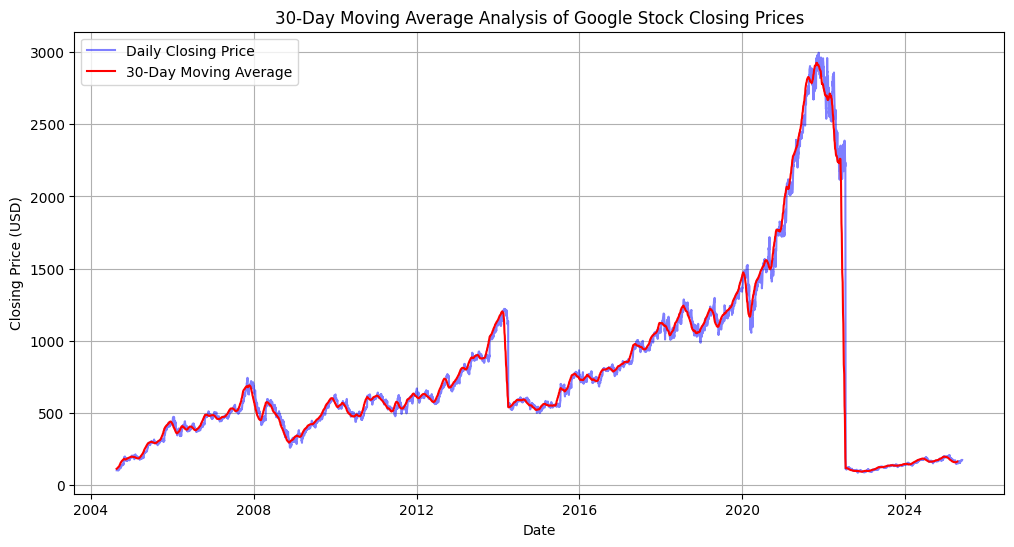

In [14]:
googl_data['Moving Average (30 days)'] = googl_data['4. close'].rolling(window=30).mean()
plt.figure(figsize=(12, 6))
plt.plot(googl_data['date'], googl_data['4. close'], label='Daily Closing Price', color='blue', alpha=0.5)
plt.plot(googl_data['date'], googl_data['Moving Average (30 days)'], label='30-Day Moving Average', color='red')
plt.title('30-Day Moving Average Analysis of Google Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid()
plt.show()

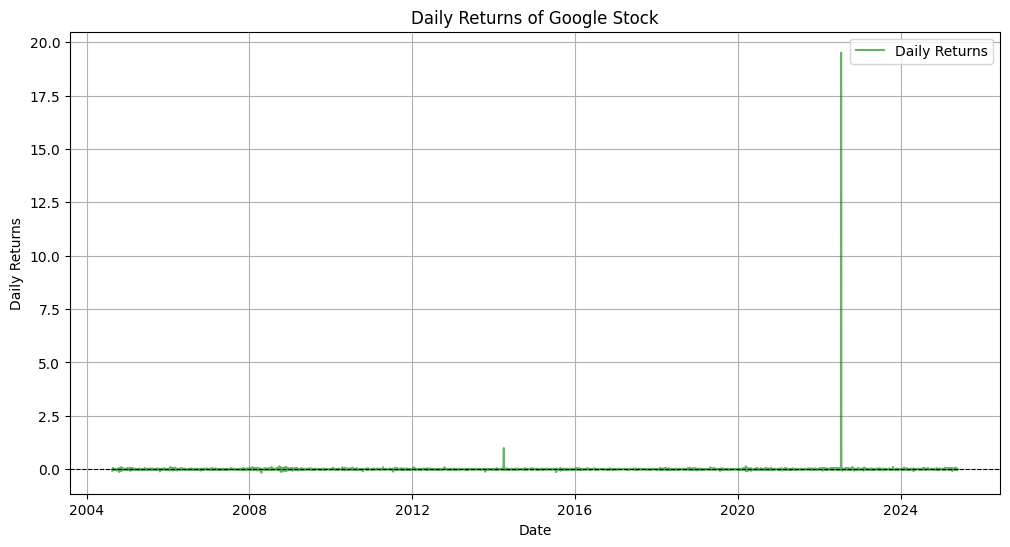

In [16]:
googl_data['Daily Returns'] = googl_data['4. close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(googl_data['date'], googl_data['Daily Returns'], label='Daily Returns', color='green', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Daily Returns of Google Stock')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
plt.show()

In [18]:
correlation_matrix = googl_data[['4. close', 'Daily Returns']].corr()
correlation_matrix

,4. close,Daily Returns
4. close,1.000000,0.034701
Daily Returns,0.034701,1.000000


<Figure size 1200x1000 with 0 Axes>

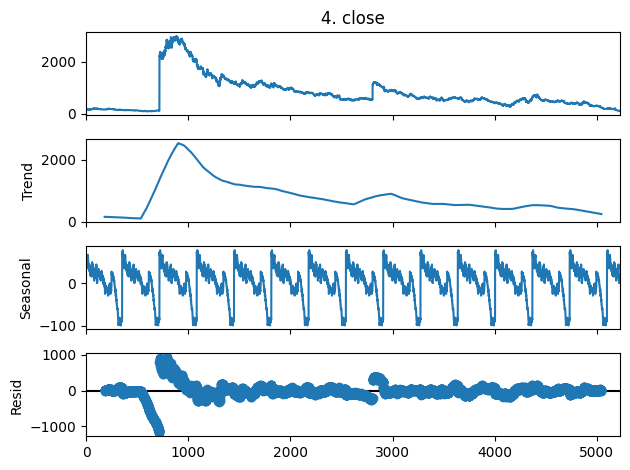

In [20]:
# Perform seasonal decomposition
result = seasonal_decompose(googl_data['4. close'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 10))
result.plot()
plt.show()

In [22]:
# Checking for missing values in the dataset
googl_data.isnull().sum()

date                         0
1. open                      0
2. high                      0
3. low                       0
4. close                     0
5. volume                    0
Moving Average (30 days)    29
Daily Returns                1
dtype: int64

In [24]:
# Checking the data types of each column
googl_data.dtypes

date                        datetime64[ns]
1. open                            float64
2. high                            float64
3. low                             float64
4. close                           float64
5. volume                          float64
Moving Average (30 days)           float64
Daily Returns                      float64
dtype: object

In [26]:
# Checking for duplicate rows in the dataset
googl_data.duplicated().sum()

0

In [28]:
# Checking the range of dates in the dataset
googl_data['date'].min(), googl_data['date'].max()

(Timestamp('2004-08-19 00:00:00'), Timestamp('2025-05-28 00:00:00'))

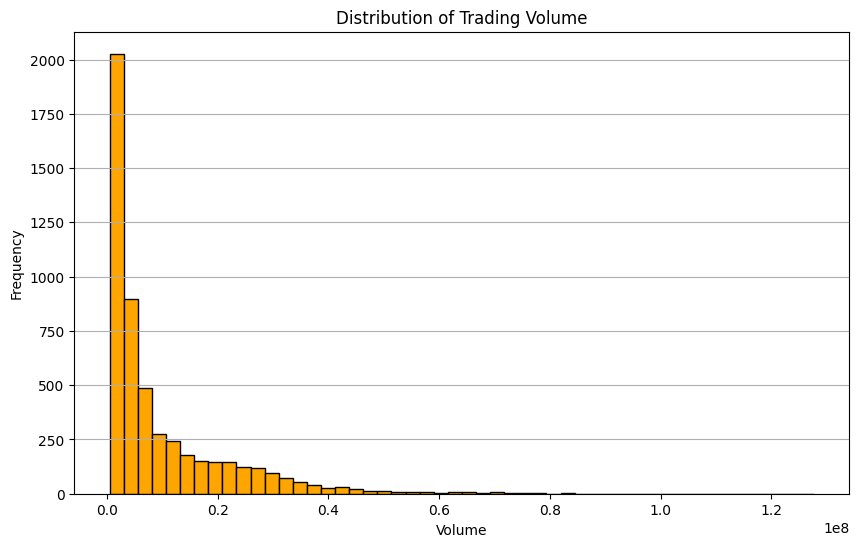

In [30]:
# Checking the distribution of the '5. volume' column to understand trading activity
plt.figure(figsize=(10, 6))
plt.hist(googl_data['5. volume'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

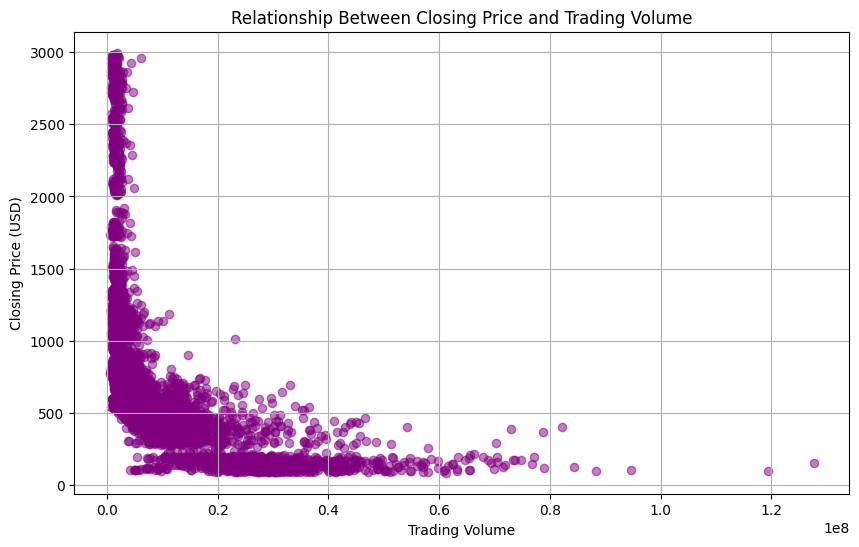

In [32]:
# Checking the relationship between '4. close' and '5. volume' using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(googl_data['5. volume'], googl_data['4. close'], alpha=0.5, color='purple')
plt.title('Relationship Between Closing Price and Trading Volume')
plt.xlabel('Trading Volume')
plt.ylabel('Closing Price (USD)')
plt.grid()
plt.show()

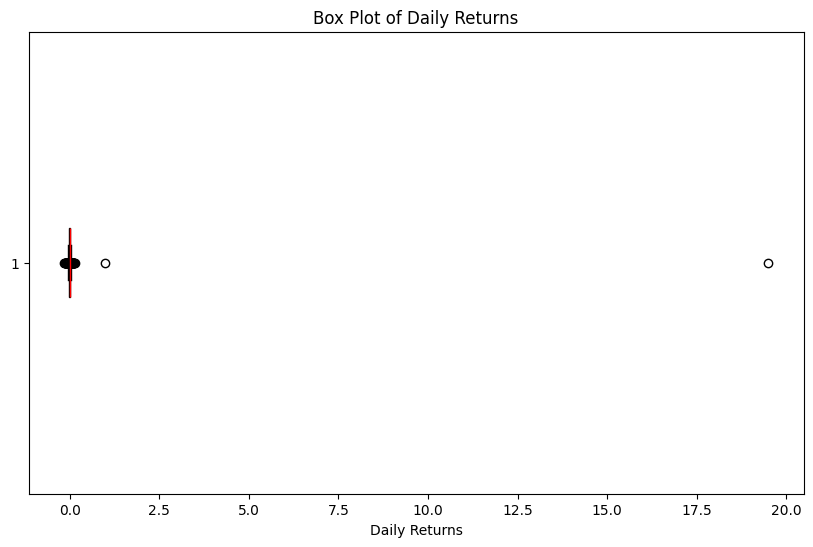

In [34]:
# Checking for outliers in the 'Daily Returns' column using a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(googl_data['Daily Returns'].dropna(), vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightgreen', color='black'), 
            medianprops=dict(color='red'))
plt.title('Box Plot of Daily Returns')
plt.xlabel('Daily Returns')
plt.show()

feature engenieering

In [37]:
# Ensure the 'date' column is in datetime format and sort the data chronologically
googl_data['date'] = pd.to_datetime(googl_data['date'])
googl_data = googl_data.sort_values(by='date').reset_index(drop=True)

# Create lag features
googl_data['Previous Day Close'] = googl_data['4. close'].shift(1)
googl_data['7-Day Moving Average'] = googl_data['4. close'].rolling(window=7).mean()
googl_data['15-Day Moving Average'] = googl_data['4. close'].rolling(window=15).mean()

googl_data

,date,1. open,2. high,3. low,4. close,5. volume,Moving Average (30 days),Daily Returns,Previous Day Close,7-Day Moving Average,15-Day Moving Average
0,2004-08-19,100.010,104.060,95.9600,100.335,44659000.0,110.837500,-0.073631,NaN,NaN,NaN
1,2004-08-20,101.010,109.080,100.5000,108.310,22834300.0,111.912333,-0.009963,100.335,NaN,NaN
2,2004-08-23,110.760,113.480,109.0500,109.400,18256100.0,112.804000,0.043196,108.310,NaN,NaN
3,2004-08-24,111.240,111.600,103.5700,104.870,15247300.0,113.769667,-0.010660,109.400,NaN,NaN
4,2004-08-25,104.760,108.000,103.8800,106.000,9188600.0,114.843333,-0.017700,104.870,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5222,2025-05-21,163.690,173.140,163.5600,168.560,73415956.0,NaN,-0.013519,163.980,164.875714,161.584667
5223,2025-05-22,171.850,176.770,170.7100,170.870,74864418.0,NaN,0.014246,168.560,166.495714,162.222667
5224,2025-05-23,169.055,169.960,167.8900,168.470,35211439.0,NaN,-0.025622,170.870,166.938571,162.518667
5225,2025-05-27,170.160,173.170,170.0000,172.900,37995670.0,NaN,0.003133,168.470,168.215714,163.098000


In [41]:
# Dropping rows with NaN values due to lag features
googl_data = googl_data.dropna()

# Define the features and target variable
features = ['1. open', '2. high', '3. low', '5. volume', 'Previous Day Close', '7-Day Moving Average', '15-Day Moving Average']
target = '4. close'

# Selecting features to normalize
features_to_normalize = ['1. open', '2. high', '3. low', '4. close', '5. volume', 'Previous Day Close', '7-Day Moving Average', '15-Day Moving Average']

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

googl_data[features_to_normalize] = scaler.fit_transform(googl_data[features_to_normalize])

# Splitting the data into training and testing sets with a better split strategy
train_size = int(len(googl_data) * 0.8)
train_data = googl_data.iloc[:train_size]
test_data = googl_data.iloc[train_size:]

# Splitting the data into features (X) and target (y)
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

X_train, y_train, X_test, y_test

(       1. open   2. high    3. low  5. volume  Previous Day Close  \
 14    0.005817  0.005499  0.006101   0.030222            0.006477   
 15    0.005467  0.006806  0.006205   0.069192            0.006481   
 16    0.007222  0.007434  0.007987   0.062009            0.007517   
 17    0.007498  0.008654  0.008101   0.087094            0.008262   
 18    0.008559  0.009411  0.009279   0.086120            0.009632   
 ...        ...       ...       ...        ...                 ...   
 4156  0.656072  0.674491  0.658766   0.010650            0.676485   
 4157  0.661532  0.679864  0.671652   0.005587            0.678496   
 4158  0.670340  0.678057  0.664383   0.013294            0.686628   
 4159  0.661502  0.669064  0.662490   0.012716            0.663335   
 4160  0.667642  0.675758  0.674032   0.007038            0.665381   
 
       7-Day Moving Average  15-Day Moving Average  
 14                0.004872               0.005439  
 15                0.005019               0.005555  

Random Forest Regressor


In [44]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(0.011167698012730733, 0.9287709206867542)

The Random Forest Regressor has been trained and evaluated. The Mean Squared Error (MSE) is 0.0112, and the R-squared (R²) score is 0.9288, indicating a strong model performance.

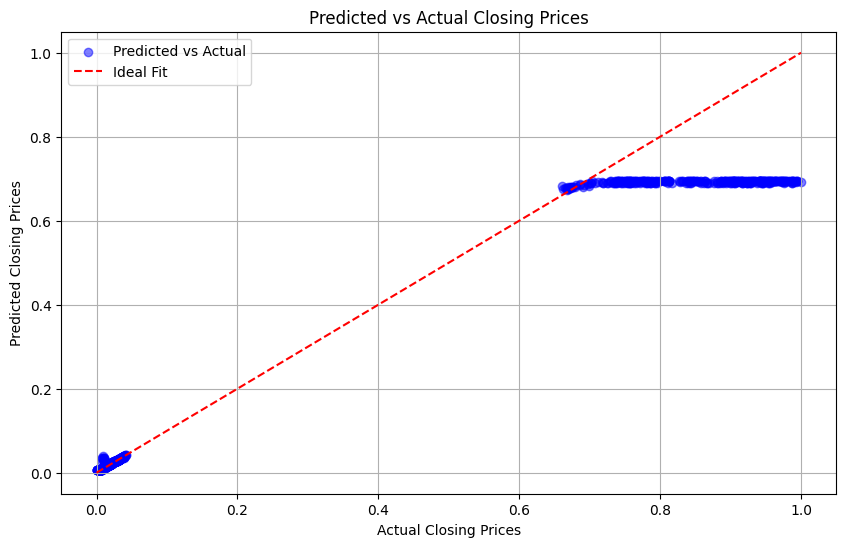

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Actual Closing Prices')
plt.ylabel('Predicted Closing Prices')
plt.legend()
plt.grid()
plt.show()

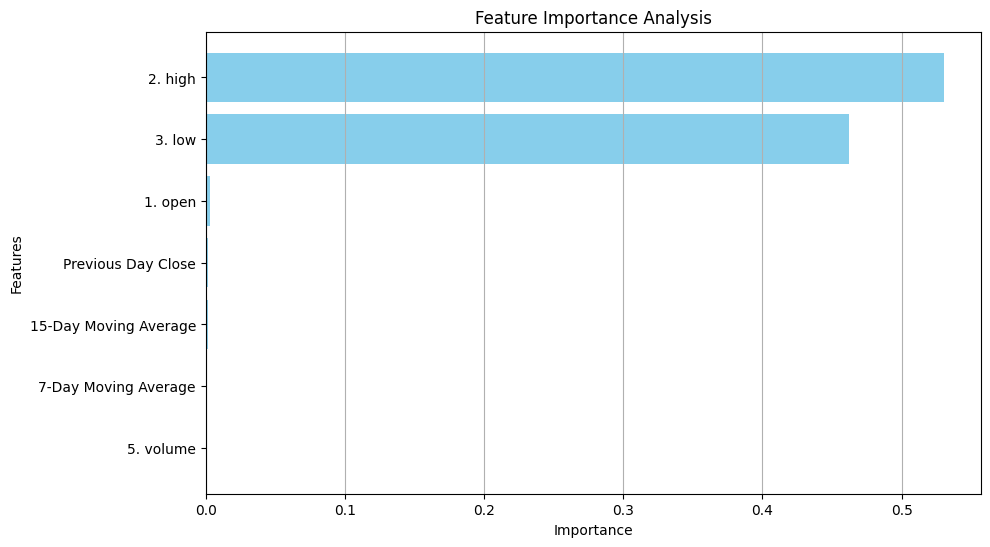

,Feature,Importance
1,2. high,0.530307
2,3. low,0.462351
0,1. open,0.003132
4,Previous Day Close,0.001627
6,15-Day Moving Average,0.001517
5,7-Day Moving Average,0.001038
3,5. volume,0.000028


In [49]:
# Extracting feature importances from the Random Forest model
importances = rf_regressor.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizing feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance Analysis')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

feature_importance_df

In [51]:
# Preparing the data for GRU model
X_train_gru = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

# Building the GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
    Dense(1)
])

# Compiling the model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Training the model
gru_model.fit(X_train_gru, y_train, epochs=20, batch_size=32, verbose=0)

# Making predictions
y_pred_gru = gru_model.predict(X_test_gru)

# Evaluating the model
gru_mse = mean_squared_error(y_test, y_pred_gru)
gru_r2 = r2_score(y_test, y_pred_gru)

gru_mse, gru_r2

C:\Users\dmade\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(0.0008553381175346046, 0.9945445384944988)

The GRU model has been trained and evaluated. The Mean Squared Error (MSE) is 0.00086, and the R-squared (R²) score is 0.9945, indicating excellent model performance.

C:\Users\dmade\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dmade\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dmade\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dmade\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


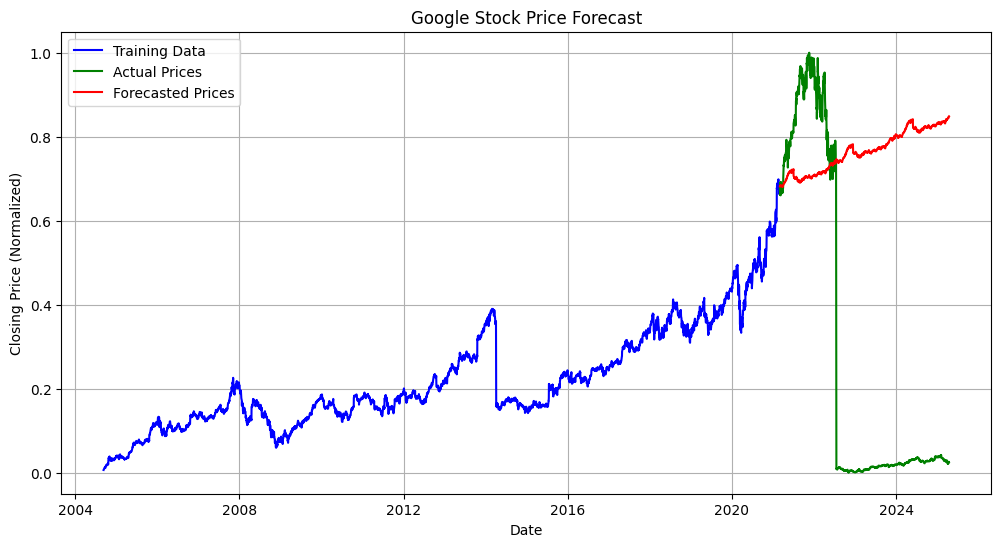

In [54]:
# Extracting the closing prices and dates for forecasting
closing_prices = googl_data['4. close']
dates = googl_data['date']

# Splitting the data into training and testing sets for time series forecasting
train_size = int(len(closing_prices) * 0.8)
train_prices = closing_prices[:train_size]
test_prices = closing_prices[train_size:]

# Fitting the Exponential Smoothing model
model = ExponentialSmoothing(train_prices, seasonal='add', seasonal_periods=365, trend='add')
fit_model = model.fit()

# Forecasting future prices
forecast_steps = len(test_prices)
forecast = fit_model.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(12, 6))
plt.plot(dates[:train_size], train_prices, label='Training Data', color='blue')
plt.plot(dates[train_size:], test_prices, label='Actual Prices', color='green')
plt.plot(dates[train_size:], forecast, label='Forecasted Prices', color='red')
plt.title('Google Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price (Normalized)')
plt.legend()
plt.grid()
plt.show()

In [56]:
# Calculate additional metrics for Random Forest
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

# Calculate additional metrics for GRU
gru_mae = mean_absolute_error(y_test, y_pred_gru)
gru_mse = mean_squared_error(y_test, y_pred_gru)
gru_r2 = r2_score(y_test, y_pred_gru)

# Calculate additional metrics for Exponential Smoothing
es_mae = mean_absolute_error(test_prices, forecast)
es_mse = mean_squared_error(test_prices, forecast)
es_r2 = r2_score(test_prices, forecast)

# Combine results into a dictionary
comparison_metrics = {
    'Model': ['Random Forest', 'GRU', 'Exponential Smoothing'],
    'MAE': [rf_mae, gru_mae, es_mae],
    'MSE': [rf_mse, gru_mse, es_mse],
    'R2': [rf_r2, gru_r2, es_r2]
}

comparison_metrics

{'Model': ['Random Forest', 'GRU', 'Exponential Smoothing'],
 'MAE': [0.05406664380262184, 0.013020568079877726, 0.5635178257054919],
 'MSE': [0.011167698012730733, 0.0008553381175346046, 0.4095262075768525],
 'R2': [0.9287709206867542, 0.9945445384944988, -1.6120132087285621]}

The GRU model outperforms the others with the lowest MAE and MSE and the highest R², indicating excellent predictive accuracy. The Exponential Smoothing model performs poorly, with a negative R² indicating it fails to capture the variance in the data.

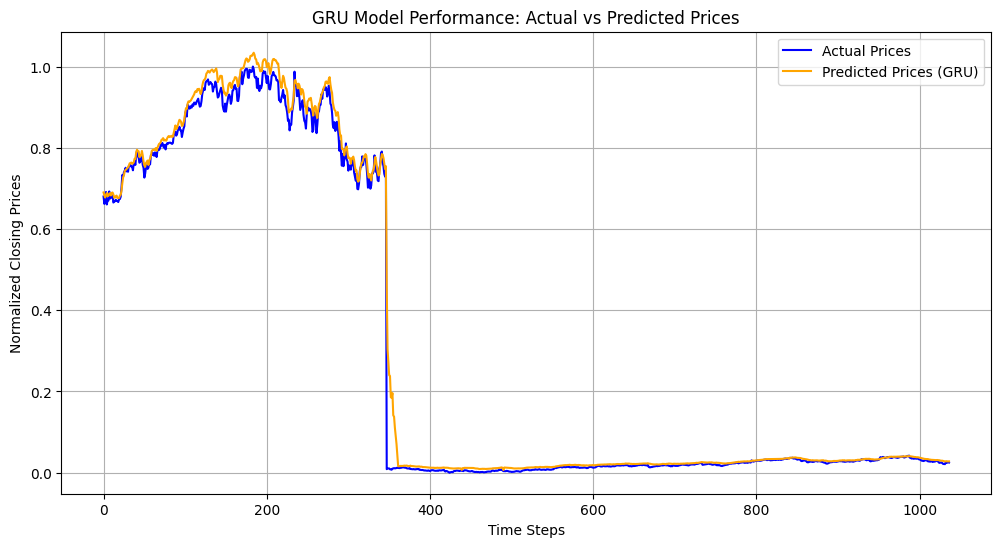

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred_gru, label='Predicted Prices (GRU)', color='orange')
plt.title('GRU Model Performance: Actual vs Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Closing Prices')
plt.legend()
plt.grid()
plt.show()

In [61]:
# Running the GRU model on the test data to make predictions
y_pred_gru = gru_model.predict(X_test_gru)
y_pred_gru

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[0.68999743],
       [0.68277955],
       [0.6774835 ],
       ...,
       [0.02789918],
       [0.02800325],
       [0.02792563]], dtype=float32)

In [63]:
# Using the last known data point to generate future predictions
forecasted_prices = []
last_known_data = X_test_gru[-1]  # Start with the last known data point

# Number of future steps to forecast
future_steps = 30

for _ in range(future_steps):
    # Predict the next price
    next_price = gru_model.predict(last_known_data.reshape(1, -1, 1), verbose=0)[0, 0]
    forecasted_prices.append(next_price)

    # Update the last known data with the predicted price
    last_known_data = np.roll(last_known_data, -1)
    last_known_data[-1] = next_price

forecasted_prices

[0.02792564,
 0.027851269,
 0.028803647,
 0.02985657,
 0.0252578,
 0.023545405,
 0.021924837,
 0.020205759,
 0.018398391,
 0.016516704,
 0.014584541,
 0.012661145,
 0.010758498,
 0.008898707,
 0.007052556,
 0.0052172504,
 0.0034368448,
 0.0017178291,
 4.443433e-05,
 -0.0015858002,
 -0.0031486666,
 -0.00464039,
 -0.0060808035,
 -0.007469385,
 -0.008807623,
 -0.01009445,
 -0.011311959,
 -0.012473526,
 -0.013582065,
 -0.014640308]

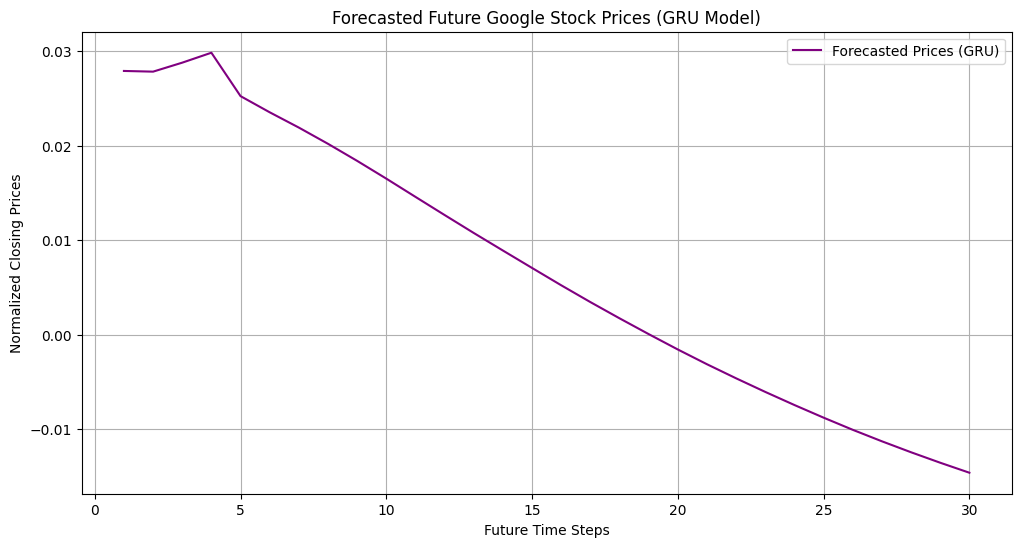

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, future_steps + 1), forecasted_prices, label='Forecasted Prices (GRU)', color='purple')
plt.title('Forecasted Future Google Stock Prices (GRU Model)')
plt.xlabel('Future Time Steps')
plt.ylabel('Normalized Closing Prices')
plt.legend()
plt.grid()
plt.show()

In [67]:
# Generating a summary report for the GRU model
summary_report = {
    'Model': 'GRU',
    'Performance Metrics': {
        'Mean Absolute Error (MAE)': gru_mae,
        'Mean Squared Error (MSE)': gru_mse,
        'R-squared (R²)': gru_r2
    },
    'Forecasted Prices (Next 30 Steps)': forecasted_prices
}

summary_report

{'Model': 'GRU',
 'Performance Metrics': {'Mean Absolute Error (MAE)': 0.013020568079877726,
  'Mean Squared Error (MSE)': 0.0008553381175346046,
  'R-squared (R²)': 0.9945445384944988},
 'Forecasted Prices (Next 30 Steps)': [0.02792564,
  0.027851269,
  0.028803647,
  0.02985657,
  0.0252578,
  0.023545405,
  0.021924837,
  0.020205759,
  0.018398391,
  0.016516704,
  0.014584541,
  0.012661145,
  0.010758498,
  0.008898707,
  0.007052556,
  0.0052172504,
  0.0034368448,
  0.0017178291,
  4.443433e-05,
  -0.0015858002,
  -0.0031486666,
  -0.00464039,
  -0.0060808035,
  -0.007469385,
  -0.008807623,
  -0.01009445,
  -0.011311959,
  -0.012473526,
  -0.013582065,
  -0.014640308]}

In [69]:
save_model(gru_model, './gru_model.h5')